## RNN Project

In [18]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import tensorflow as tf 
keras = tf.keras

### Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

In [4]:
df = pd.read_csv('../DATA/Frozen_Dessert_Production.csv', parse_dates=True, index_col='DATE')
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [6]:
df.columns = ['Production']
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


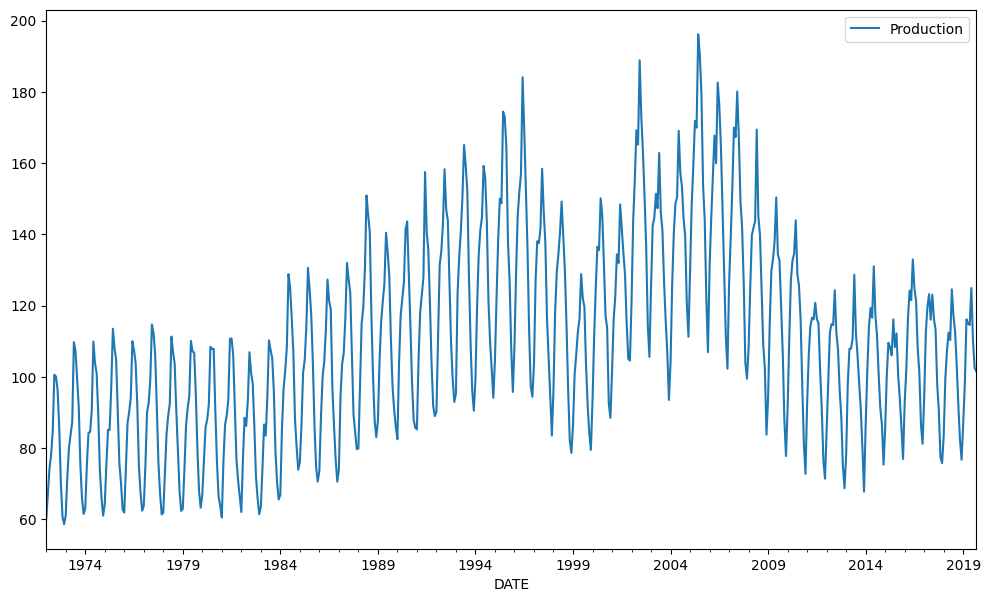

In [9]:
df.plot(figsize=(12,7));

In [10]:
len(df)

573

In [14]:
testsize = 24

cut_off_ind = len(df) - testsize

In [15]:
X = df.iloc[:cut_off_ind]
y = df.iloc[cut_off_ind:]

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [17]:
scaled_X = scaler.fit_transform(X)
scaled_y = scaler.transform(y)

In [20]:
from keras.preprocessing.sequence import TimeseriesGenerator

length = 18
n_features=1

generator = TimeseriesGenerator(scaled_X, scaled_X, length=length, batch_size=1)

In [23]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()

model.add(LSTM(units=128, activation='relu', input_shape = (length, n_features)))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
val_generator = TimeseriesGenerator(scaled_y, scaled_y, length=length, batch_size=1)

In [26]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [27]:
model.fit(generator, epochs=20, callbacks=[early_stop], validation_data=val_generator)

Epoch 1/20
531/531 [==============================] - 9s 13ms/step - loss: 0.0261 - val_loss: 0.0051
Epoch 2/20
531/531 [==============================] - 5s 9ms/step - loss: 0.0096 - val_loss: 0.0021
Epoch 3/20
531/531 [==============================] - 5s 9ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 4/20
531/531 [==============================] - 5s 10ms/step - loss: 0.0040 - val_loss: 0.0032


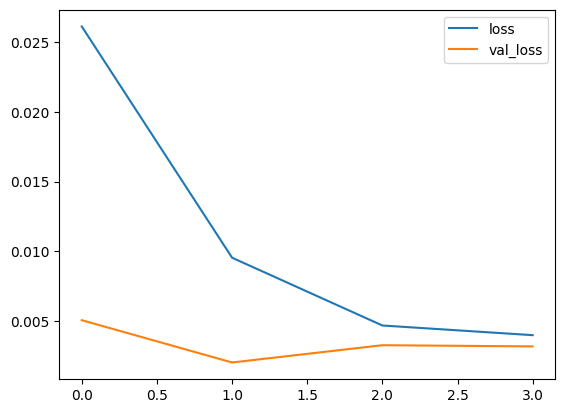

In [30]:
losses = pd.DataFrame(model.history.history)
losses.plot();

In [37]:
test_predictions = []

first_eval_batch = scaled_X[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_y)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [42]:
true_predictions = scaler.inverse_transform(test_predictions)

y['predictions'] = true_predictions

/var/folders/pm/w4my5ldn7sb_bn0xl6s0f2c00000gn/T/ipykernel_5107/4253730824.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['predictions'] = true_predictions


In [43]:
y

,Production,predictions
DATE,,
2017-10-01,90.4732,91.875510
2017-11-01,77.4378,86.711102
2017-12-01,75.8118,88.595593
2018-01-01,83.4343,97.010512
2018-02-01,99.4899,109.403587
2018-03-01,107.3152,119.734873
2018-04-01,112.4309,126.459853
2018-05-01,110.3544,129.884821
2018-06-01,124.5841,128.737217


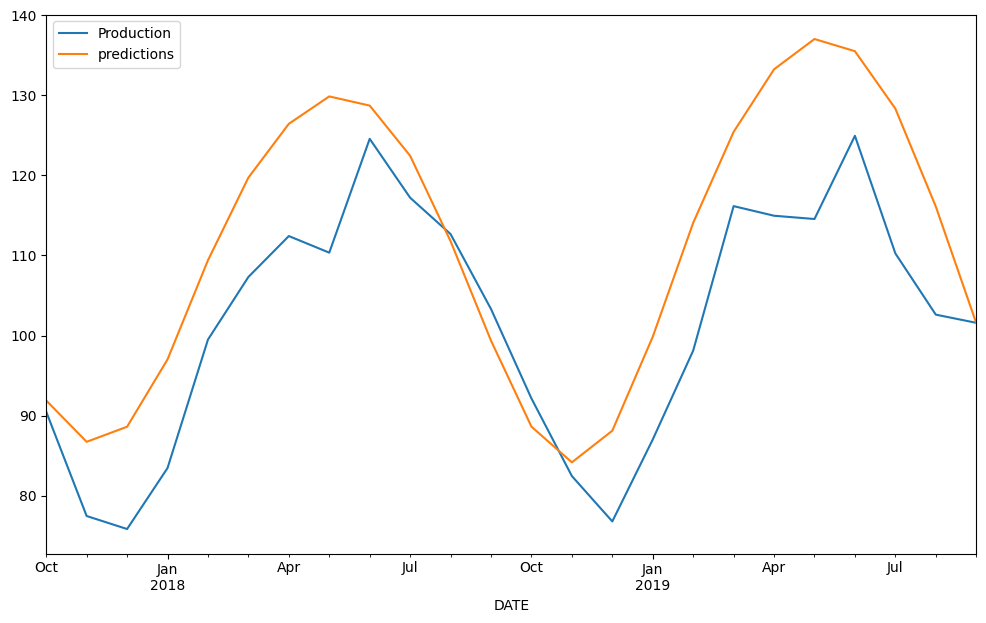

In [45]:
y.plot(figsize=(12,7));

In [46]:
from sklearn.metrics import mean_squared_error

RMSE = np.sqrt(mean_squared_error(y['Production'], y['predictions']))
RMSE

11.973242536466724